**Kimlik Doğrulama**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lokalizasyon (Yerelleştirme) İşlemi**

In [ ]:
!mkdir -p drive
!ls

drive  sample_data


**Dosya Yerini Belirleme İşlemi**

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Etkinlik2/Vehicle")
!pwd


/content/drive/MyDrive/Etkinlik2/Vehicle


**Gerekli Kütüphanelerin Yüklenmesi**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

#Veri Ön İşleme
from os import listdir, mkdir
import imageio
from skimage.transform import resize

#Veriseti Bölme (Verisetini Eğitim-Test-Geçerleme Veri Kümesine Bölme ve Etiketleri Kodlama)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


**Veri Ön İşleme**

In [ ]:
etiketler = listdir("Orjinal")
etiketler.sort()

In [ ]:
for i, etiket in enumerate(etiketler):
    mkdir("OnIslem" + "/" + etiket)
    etiket_klasoru = "Orjinal" + "/" + etiket
    for resim_adi in listdir(etiket_klasoru):
        path = etiket_klasoru + "/" + resim_adi
        resim = imageio.imread(path, as_gray=True)
        resim.flatten();
        resim = resize(resim, (96, 96, 1))
        imageio.imwrite("OnIslem" + "/" + etiket + "/" + resim_adi, resim)



**Veriseti Bölme**

In [ ]:
X, Y = [], []
for i, etiket in enumerate(etiketler):
    etiket_klasoru = "OnIslem" + '/' + etiket
    for resim_adi in listdir(etiket_klasoru):
        path = etiket_klasoru + "/" + resim_adi
        resim = imageio.imread(path, as_gray=True)
        resim.flatten();
        resim = resize(resim, (96, 96, 1))
        X.append(resim)
        Y.append(i)

X = np.array(X).astype('float32')/255.

X = X.reshape(X.shape[0], 96, 96, 1)
Y = np.array(Y).astype('float32')
Y = to_categorical(Y, 3) #etiketSayisi: 3

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.222110553, random_state=42, stratify=y)
np.save('VeriSeti/x_train.npy', x_train)
np.save('VeriSeti/x_test.npy', x_test)
np.save('VeriSeti/x_val.npy', x_val)
np.save('VeriSeti/y_train.npy', y_train)
np.save('VeriSeti/y_test.npy', y_test)
np.save('VeriSeti/y_val.npy', y_val)


<ipython-input-7-01fe2fabafdc>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  resim = imageio.imread(path, as_gray=True)


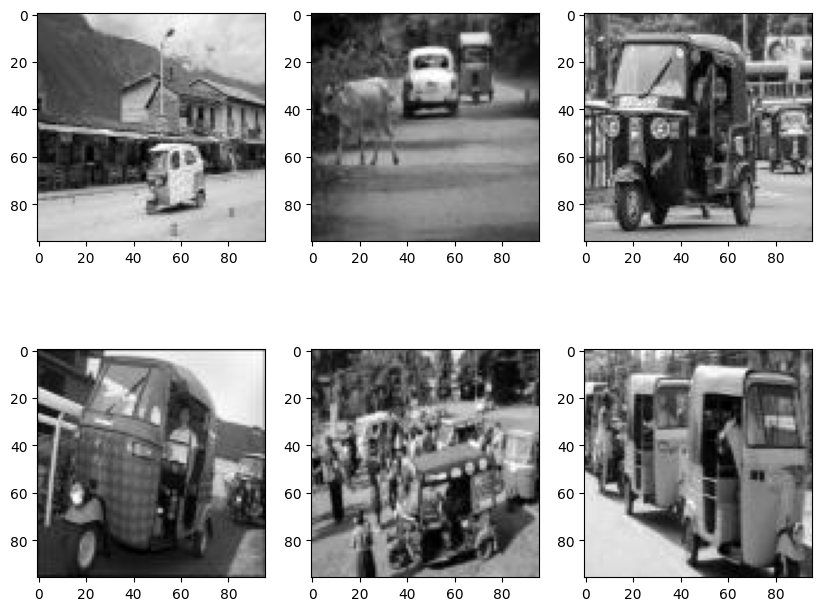

In [ ]:
fig,axes = plt.subplots(2,3,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X[i],cmap=plt.get_cmap('gray'))

**Eğitim-Test**

In [ ]:

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Conv2D
x_train = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/x_train.npy')
x_test = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/x_test.npy')
x_val = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/x_val.npy')
y_train = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/y_test.npy')
y_val = np.load('/content/drive/MyDrive/Etkinlik2/Vehicle/VeriSeti/y_val.npy')


In [ ]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1))) #en, boy, kanal
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='sigmoid')) #etiketSayisi:2
model.summary()
model.compile(loss=keras.losses.binary_crossentropy,
              #optimizer=tf.keras.optimizers.Adamax(),
              #optimizer=tf.keras.optimizers.RMSprop(),
              #optimizer=tf.keras.optimizers.SGD(lr=0.1),
              optimizer=tf.keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])
history = model.fit (x_train, y_train,batch_size=32, epochs=13, verbose=1,validation_data=(x_test, y_test))
model.save('VehicleModel.h5')
keras.backend.clear_session()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 256)       295168    
                                                        

Epoch 1/13
29/29 [==============================] - 66s 2s/step - loss: 0.6376 - accuracy: 0.3524 - val_loss: 0.6063 - val_accuracy: 0.3459
Epoch 2/13
29/29 [==============================] - 64s 2s/step - loss: 0.5264 - accuracy: 0.5614 - val_loss: 0.3712 - val_accuracy: 0.7068
Epoch 3/13
29/29 [==============================] - 61s 2s/step - loss: 0.4083 - accuracy: 0.6897 - val_loss: 0.3404 - val_accuracy: 0.7143
Epoch 4/13
29/29 [==============================] - 60s 2s/step - loss: 0.3785 - accuracy: 0.7123 - val_loss: 0.3209 - val_accuracy: 0.7368
Epoch 5/13
29/29 [==============================] - 61s 2s/step - loss: 0.2927 - accuracy: 0.8233 - val_loss: 0.2230 - val_accuracy: 0.8571
Epoch 6/13
29/29 [==============================] - 61s 2s/step - loss: 0.2563 - accuracy: 0.8481 - val_loss: 0.2043 - val_accuracy: 0.8647
Epoch 7/13
29/29 [==============================] - 62s 2s/step - loss: 0.1945 - accuracy: 0.8772 - val_loss: 0.1481 - val_accuracy: 0.9023
Epoch 8/13
29/29 [==

**Geçerleme**

In [ ]:

score = model.evaluate(x_val, y_val, verbose=0)
print('Geçerleme Loss/Kayıp:', score[0])
print('Geçerleme Accuracy/Doğruluk:', score[1])


Geçerleme Loss/Kayıp: 0.10481099784374237
Geçerleme Accuracy/Doğruluk: 0.9433962106704712


**Grafiklendirme (Eğitim-Test)**

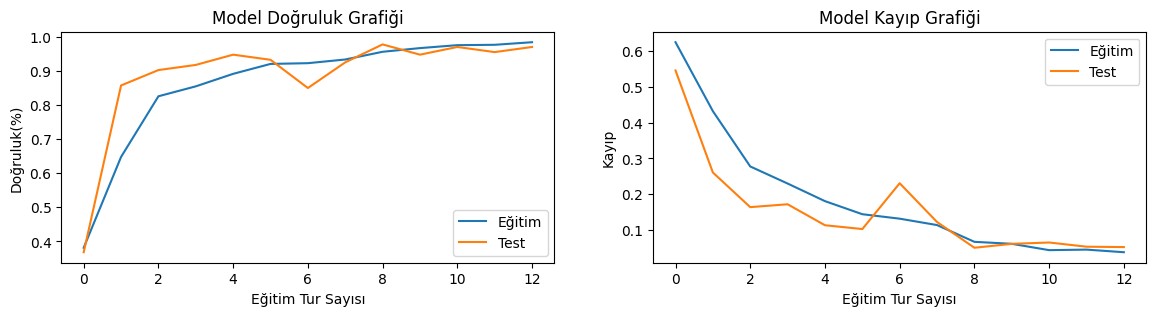

In [ ]:

from matplotlib import pyplot as plt
#Model Doğruluk ve Kayıp Grafikleri
plt.figure(figsize=(14.,3.))
plt.subplots_adjust(hspace=0.4)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Doğruluk Grafiği')
plt.ylabel('Doğruluk(%)')
plt.xlabel('Eğitim Tur Sayısı')
plt.legend(['Eğitim', 'Test'], loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kayıp Grafiği')
plt.ylabel('Kayıp')
plt.xlabel('Eğitim Tur Sayısı')
plt.legend(['Eğitim', 'Test'], loc='upper right')
plt.show()


**9. Grafiklendirme (Geçerleme)**

9/9 [==============================] - 4s 436ms/step
[[79  7  2]
 [ 1 87  0]
 [ 0  3 86]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        88
           1       0.90      0.99      0.94        88
           2       0.98      0.97      0.97        89

    accuracy                           0.95       265
   macro avg       0.95      0.95      0.95       265
weighted avg       0.95      0.95      0.95       265



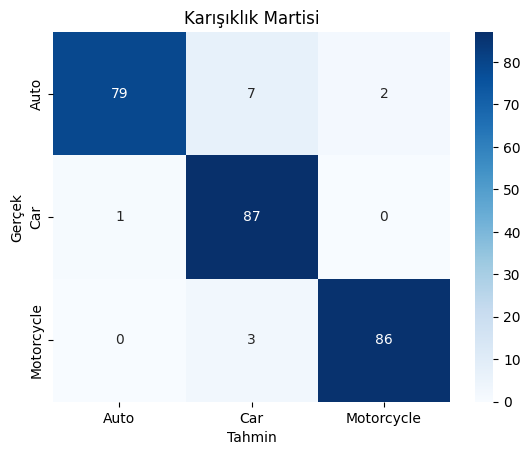

In [ ]:

#Karışılık Matrisi (Confusion Matrix)
from sklearn.metrics import confusion_matrix, classification_report
y_true = np.argmax(y_val, axis=1)
predict_x = model.predict(x_val)
y_pred = np.argmax(predict_x, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
classification_report = classification_report(y_true, y_pred)
print(classification_report)
import seaborn as sns
import pandas as pd
classes = ['Auto', 'Car', 'Motorcycle']
cf_matrix_df = pd.DataFrame(cf_matrix,
index = classes,
columns = classes)
sns.heatmap(cf_matrix_df, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.title('Karışıklık Martisi')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()